# One-dimensional bandwidth sweep

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from jax.scipy.stats import norm

import matplotlib as mpl
import matplotlib.pyplot as plt

from svgd import SVGD
from utils import dict_concatenate, dict_mean
from tqdm import tqdm

import metrics
import utils
import plot

In [2]:
n=100
d=1
stepsize = 0.01
L = 100 # 100 slightly to little, this should be all right
grid_length = 50

dist = metrics.GaussianMixture([-2, 2], [1, 1], [1/3, 2/3])

svgd_fix = SVGD(dist, n_iter_max=L, adaptive_kernel=False)
svgd_ada = SVGD(dist, n_iter_max=L, adaptive_kernel=True)

bandwidth_grid = np.linspace(0.4, 7, num=grid_length)
# bandwidth_grid = np.logspace(-1.5, 5, num=grid_length)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
def sweep(rkey, grid):
    """Sweep a grid of bandwidth values and output corresponding metrics."""
    sweep_results = []
    for h in tqdm(grid):
        x0 = svgd_fix.initialize(rkey, n)
        xout, _ = svgd_fix.svgd(x0, stepsize, h, L)
        metrics = dist.compute_metrics(xout)
        sweep_results.append(metrics)
    return {k: np.stack([metrics[k] for metrics in sweep_results], axis=0) for k in dist.metric_names.keys()}
# entries in dict have shapes (k, 3, d) and (k, 3)

In [4]:
m = 10
metrics_sweep = []
sweeps = []
for i in range(m):
#     print(f"Sweep {i+1} of {m}")
    svgd_fix.newkey()
    s = sweep(svgd_fix.rkey, bandwidth_grid)
    sweeps.append(s)

  0%|          | 0/50 [00:00<?, ?it/s]

JIT COMPILING svgd...
...done compiling svgd after 0.7280747890472412 seconds.


100%|██████████| 50/50 [00:01<00:00, 46.93it/s]


In [5]:
sweeps = dict_mean(sweeps)

Then get the same metrics for the adaptive bandwidth:

In [6]:
adas = []
for _ in range(m):
    x0 = svgd_ada.initialize(n=n)
#     svgd_ada.newkey()
    xout, _ = svgd_ada.svgd(x0, stepsize, 0, L)
    metrics_ada = dist.compute_metrics(xout)
    adas.append(metrics_ada)
adas = dict_mean(adas)

JIT COMPILING svgd...
...done compiling svgd after 0.49591660499572754 seconds.


Now get same metrics for true random sample:

In [7]:
m = 100

In [8]:
true = []
for _ in range(m):
    sample = dist.sample(shape=(n,d))
    true_metrics = dist.compute_metrics(sample)
    true.append(true_metrics)
true = dict_mean(true)

In [9]:
true

{'square_errors': DeviceArray([[0.04584731],
              [0.17661822],
              [0.00332431],
              [0.00429959]], dtype=float32),
 'ksds': DeviceArray([97.342224 ,  1.7476947,  0.7715106], dtype=float32)}

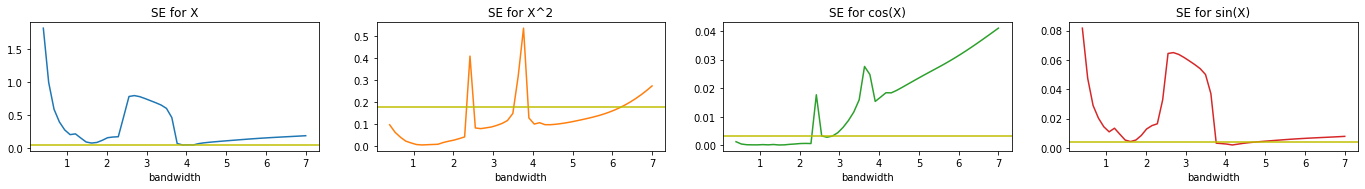

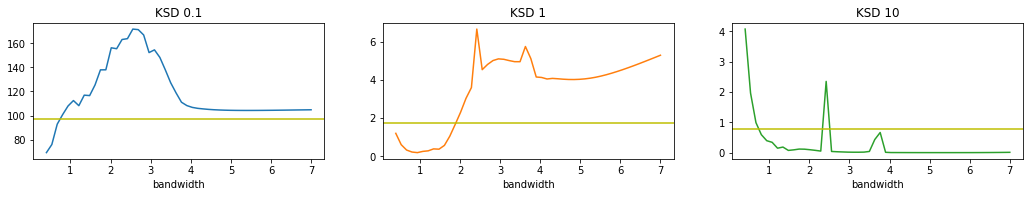

In [10]:
for k, v in sweeps.items():
    plot.plotobject(np.rollaxis(v, axis=1), xaxis=bandwidth_grid, titles=dist.metric_names[k], 
                    xscale="linear", xlabel="bandwidth", axhlines=true[k])

# Two-dimensional bandwidth sweep

For bandwidth values $(h, h)$ with $h$ in the range $10-100$ we get very bad results: MSE and KSD values larger than $10^3$.

In [11]:
n=100
d=2
stepsize = 0.01
L = 100
grid_length = 25

In [12]:
mean = np.array([1,2])
cov = np.array([[1,1], [1, 2]])
dist = metrics.Gaussian(mean, cov)

svgd_fix = SVGD(dist, n_iter_max=L, adaptive_kernel=False)
svgd_ada = SVGD(dist, n_iter_max=L, adaptive_kernel=True)

In [13]:
# bandwidth_grid = np.logspace(-3, 5, num=grid_length)
# bandwidth_grid = np.logspace(-0.5, 2, num=grid_length)
bandwidth_grid = np.linspace(0.3, 2.5, num=grid_length)
ksd_bandwidths = [0.5, 0.8, 1, 1.5, 2, 2.5]
metric_names = ["MSE X"] +  [f"KSD {h}" for h in ksd_bandwidths]


bandwidth_grid = np.tile(bandwidth_grid, (d, 1))
bandwidth_grid = np.transpose(bandwidth_grid)
bandwidth_grid.shape

(25, 2)

In [14]:
m = 10
metrics_sweep = []
sweeps = []
for i in range(m):
    svgd_fix.newkey()
    s = sweep(svgd_fix.rkey, bandwidth_grid)
    sweeps.append(s)

  0%|          | 0/25 [00:00<?, ?it/s]

JIT COMPILING svgd...
...done compiling svgd after 0.6949508190155029 seconds.


100%|██████████| 25/25 [00:01<00:00, 21.65it/s]


In [15]:
sweeps = dict_mean(sweeps)

Then get the same metrics for the adaptive bandwidth:

In [16]:
adas = []
for _ in range(m):
    x0 = svgd_ada.initialize(n=n)
    xout, _ = svgd_ada.svgd(x0, stepsize, 0, L)
    metrics_ada = dist.compute_metrics(xout)
    adas.append(metrics_ada)
adas = dict_mean(adas)

JIT COMPILING svgd...
...done compiling svgd after 0.2757375240325928 seconds.


Now get same metrics for true random sample:

In [17]:
m = 100

In [18]:
dist.d

2

In [19]:
true = []
for _ in range(m):
    sample = dist.sample(shape=(n,))
    true_metrics = dist.compute_metrics(sample)
    true.append(true_metrics)
true = dict_mean(true)

In [20]:
sweeps = dict_mean(sweeps)

KeyError: 0

In [ ]:
for k, v in sweeps.items():
    v = np.rollaxis(v, axis=1)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    sq = int(np.sqrt(len(v)))
    w = sq + 3
    h = sq
    plt.figure(figsize = [6*w, 2.5*h + 0.2*(h-1)]) # 0.2 = hspace
    
    titles = dist.metric_names[k]
    hlines = true[k]
    for i, v in enumerate(v):
        print("v:", v.shape)
        plt.subplot(f"{h}{w}{i+1}")
        plt.plot(bandwidth_grid, v, "-", color=colors[i])
        plt.title(titles[i])

        plt.yscale("linear")
        plt.xscale("linear")
        
        plt.xlabel("step")
        print(hlines.shape)
        if hlines[i].ndim == 0:
            plt.axhline(y=hlines[i], color="y")
        else:
            for val in hlines[i]:
                plt.axhline(y=val, color="y")


## same thing for larger bandwidths

In [ ]:
bandwidth_grid = np.linspace(2.5, 5, num=grid_length)
ksd_bandwidths = [2.5, 3, 3.5, 4, 4.5, 5]
metric_names = ["MSE X"] +  [f"KSD {h}" for h in ksd_bandwidths]


bandwidth_grid = np.tile(bandwidth_grid, (d, 1))
bandwidth_grid = np.transpose(bandwidth_grid)

m = 5
metrics_sweep = []
sweeps = []
for i in range(m):
#     print(f"Sweep {i+1} of {m}")
    svgd_fix.newkey()
    s = sweep(svgd_fix.rkey, bandwidth_grid, ksd_bandwidths)
    sweeps.append(s)
sweeps = np.array(sweeps)
sweeps = np.mean(sweeps, axis=0)
sweeps = np.transpose(sweeps) # (num_metrics, bandwidth_length)
assert not np.any(np.isnan(sweeps))
sweeps1 = sweeps

adas = []
for _ in tqdm(range(m)):
    svgd_ada.newkey()
    xout, _ = svgd_ada.svgd(svgd_ada.rkey, stepsize, 0, L)
    metrics_ada = get_metrics(xout, logp, ksd_bandwidths)
    adas.append(metrics_ada)
adas = np.array(adas)
metrics_ada = np.mean(adas, axis=0)
metrics_ada1 = metrics_ada

In [ ]:
plt.figure(1, figsize=[16.0, 10.0])
plt.subplots_adjust(hspace=0.8)
col = plt.rcParams['axes.prop_cycle'].by_key()['color']
l = sweeps.shape[0]
k = l // 2

for i, sw in enumerate(sweeps1):
    plt.subplot(f"{l-k}{k}{i+1}")
    plt.title(metric_names[i])
    plt.plot(bandwidth_grid, sw, ".", color=col[i])
#     plt.xscale('log')
    plt.yscale('log')
    plt.axhline(y=float(metrics_ada1[i]), color="y")

## takeaways
* whichever way we measure it, kernel choice has large effect on accuracy
* the KSD measure with kernel parameter $h$ favours SVGD with same kernel parameter (it makes sense that this is the case, since SVGD minimizes the KL divergence in the space of distributions given by smooth transformations in the RKHS of the kernel with parameter $h$).
* this means that some measures are better than others. In particular, it is likely that choosing the right kernel for use in the KSD measure is not much easier than choosing the right kernel directly.

This leaves us with a few possibilities:
1. Hope that choosing a sufficiently good kernel for KSD is in fact easier than choosing the right kernel directly
2. Don't choose the KSD kernel parameter separately. Always use the same kernel for SVGD and for computing the loss.
3. Choose a different loss (e.g. find a way to approximate the KL divergence).

## Random grid search

In [ ]:
grid_length = 100
rkey = random.PRNGKey(123)
scale = "linear"
if scale == "log":
    bandwidth_grid = random.uniform(rkey, shape=(grid_length, d)) * 2.5 - 0.5 #* 25 - 10
    bandwidth_grid = 10**bandwidth_grid
else:
    mi, ma = [0.3, 2.5]
    bandwidth_grid = random.uniform(rkey, shape=(grid_length, d)) * (ma - mi) + mi

In [ ]:
m = 5
metrics_sweep = []
sweeps = []
for i in range(m):
#     print(f"Sweep {i+1} of {m}")
    svgd_fix.newkey()
    s = sweep(svgd_fix.rkey, bandwidth_grid, ksd_bandwidths)
    sweeps.append(s)
sweeps = np.array(sweeps)
sweeps = np.mean(sweeps, axis=0)
sweeps = np.transpose(sweeps) # (num_metrics, bandwidth_length)

### Scatterplot

In [ ]:
def scatter(grid, data):
#     plt.figure(1, figsize=[8, 8])
    x, y = grid.transpose()
    colors = data
    colors = np.log(colors)

    plt.scatter(x, y, s=100, c=colors)
    plt.xscale(scale)
    plt.yscale(scale)
    plt.xlabel("h1")
    plt.ylabel("h2")

    for i, v in enumerate(data):
        if i % 5 == 0:
            plt.annotate(v, (x[i], y[i]))

In [ ]:
plt.figure(1, figsize=[16.0, 24.0])
# plt.subplots_adjust(hspace=0.8)
l = sweeps.shape[0]
k = l // 2

for i, sw in enumerate(sweeps):
    plt.subplot(f"{l-k}{k}{i+1}")
    plt.title(metric_names[i])
    scatter(bandwidth_grid, sweeps[i])
# scatter(bandwidth_grid, sweeps[2])
# plt.title(metric_names[2])